# Water Cover

To highlight the increasing exposed area of playa we map data from the National Land Cover Database and mask it to only show the open water area. We then layer and compare the years 2004 to 2019 to see how much more of the playa as been exposed.

In [1]:
#import necessary packages
# Rasterio documentation can be found at https://rasterio.readthedocs.io/en/latest/

import numpy as np
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd

# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import contextily as ctx


In [2]:
years = [2004, 2019] # create a list of the comparison years to loop over
data = {} # Create an empty dictionary to save the raster dataset to 
data_masked = {} # Create empty dictionary to save masked numpy array to

In [9]:
#Loop through years specified to create data needed to plot
for year in years:
    #
    src_url = f'data/NLCD/NLCD_{str(year)}_Land_Cover_L48_20210604_gyGbthZM9gweVLuKaW5e.tiff'
   
   #Following code to project original raster to web mercator created from chatGPT with modifications.
    with rasterio.open(src_url) as src:
        src_crs = src.crs
        src_array = src.read(1)

    # Define the target CRS as epsg:4326
    dst_crs = 'EPSG:4326'

    # Define the transform to apply to the raster
    transform, width, height = calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)

    # Create an empty array to hold the reprojected data
    dst_array = np.zeros((height, width), dtype=np.float32)

    # Reproject the data
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src.transform,
        src_crs=src_crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)

    # Save the reprojected data to a new raster file
    dst_path = f'data/projected_{str(year)}.tif'
    with rasterio.open(
        dst_path,
        'w',
        driver='GTiff',
        width=width,
        height=height,
        count=1,
        dtype=dst_array.dtype,
        crs=dst_crs,
        transform=transform,
    ) as dst:
        dst.write(dst_array, 1)
    
    # Note NLCD Land Cover files are too big to upload reliably to GitHub (Over 25 mb and may not be present in repo)
    data[year] = rasterio.open(dst_path) # open raster and create element in 'data' dict.
    data_masked[year] = np.ma.masked_where(data[year].read(1)!=11, data[year].read(1)) # mask raster to show only were data is '11' (Open Water)

### Mapping Change in Water Cover

Now that we have our data prepared and masked we can overlay the 2004 and 2019 data we can overlay them to highlight the areas where there used to be water but is now dry lakebed.

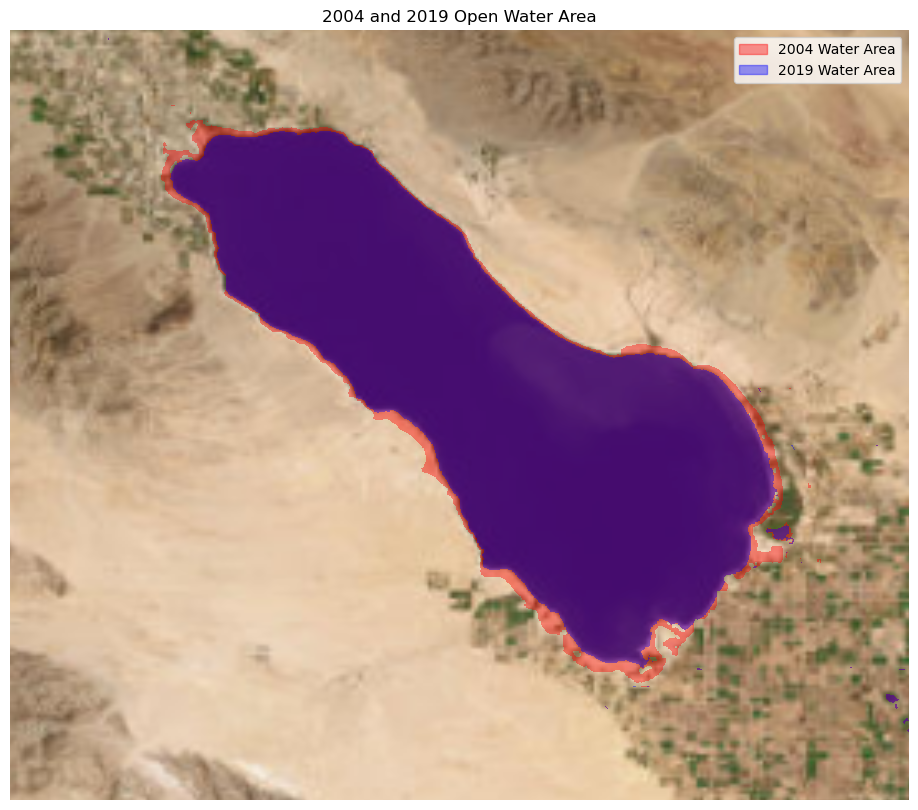

In [11]:
fig, ax = plt.subplots(figsize=(15,10)) # create a figure and axis object to map onto and set the figure size.
plt.imshow(data_masked[years[1]], extent=rasterio.plot.plotting_extent(data[years[1]]), cmap=ListedColormap(['blue']), zorder= 15, alpha=.4) #plot data, set extent to geography, set color and drawing order
plt.imshow(data_masked[years[0]], extent=rasterio.plot.plotting_extent(data[years[0]]), cmap=ListedColormap(['red']), zorder= 10, alpha=.4)

# creates legend items
handles = [
    Patch(color='red', label='2004 Water Area', alpha=.4),
    Patch(color='blue', label='2019 Water Area', alpha=.4)
]

ctx.add_basemap(
    ax, 
    crs=data[2004].read_crs(), 
    source=ctx.providers.Esri.WorldImagery, 
    zorder=5, 
    attribution_size=4
)

 #Crop image using projected reference system
plt.xlim(-116.2,-115.5)
plt.ylim(33, 33.6)
plt.axis('off')

plt.title('2004 and 2019 Open Water Area')
ax.legend(handles=handles)

plt.savefig('graphs/Water_cover.png', transparent=True)
plt.show()


This highlights the significant change in water area of the Salton Sea over this time period, but can we quantify it? 

We can with some numpy calculations! The individual pixel/cell size from NLCD is 30m by 30m, and we can count the number of cells of water in each year and calculate the difference.

In [18]:
count_19 = np.count_nonzero(data[2019].read(1) == 11)
count_04 = np.count_nonzero(data[2004].read(1) == 11)

sq_km = (count_04 - count_19)*900/1e6
pct_change = (count_19-count_04)/count_04

print(f'The area surface area of water lost between 2004 and 2019 was {sq_km} square kilometers.')
print(f'The percent change in area was {pct_change.__round__(3)}%')

The area surface area of water lost between 2004 and 2019 was 60.0876 square kilometers.
The percent change in area was -0.066%
